In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
!pip install ttach
# albumentations on your system should be at least 0.5.2
!pip3 install --upgrade albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (0.5.2)


In [29]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import ttach as tta

from sklearn.metrics import accuracy_score

import pandas as pd
import time

In [30]:
# need to set cwd to use custom modeules, data and config
cwd = '/content/drive/MyDrive/Projects/cv/cat dogs classifier/src'

import sys

sys.path.append(cwd)
os.chdir(cwd)

In [31]:
import models
import config
import transforms # in order for ToTensorV2 to work we need to update the albumentation
import dataset

In [32]:
start = time.time()

In [33]:
# setting seed
torch.manual_seed(0)
np.random.seed(0)

In [34]:
# setting device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
# just to check if everything works we only use the sample of all data
df = pd.read_csv(config.DF_PATH, usecols=['fname', 'height', 'width',
                                          'xmin_alb', 'ymin_alb', 'xmax_alb', 'ymax_alb',
                                          'label', 'kfold'])
df.shape

(3385, 9)

In [36]:
# small change to the images' paths (because the code was writen in windows)
fname = [os.path.join(config.DATA, row.split('\\')[-1]) for row in df.fname]
df.fname = fname

In [37]:
# create dataframes using folds we have got with "df_preparation.py"
train_df = df[df.kfold.isin([0, 1, 2])].reset_index(drop=True)
valid_df = df[df.kfold == 3].reset_index(drop=True)
test_df = df[df.kfold == 4].reset_index(drop=True)

# create dataset
train_dataset = dataset.localization_dataset(train_df, transforms.train_transform_loc)
valid_dataset = dataset.localization_dataset(valid_df, transforms.valid_transform_loc)
test_dataset = dataset.localization_dataset(test_df, transforms.test_transform_loc)

# create loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config.batch_size, shuffle=True)

In [38]:
# just a check if all is good with the shapes of the loaders
print(f'dataloader test: {next(iter(train_loader))[0].shape}, {next(iter(valid_loader))[0].shape}')

dataloader test: torch.Size([64, 3, 224, 224]), torch.Size([64, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


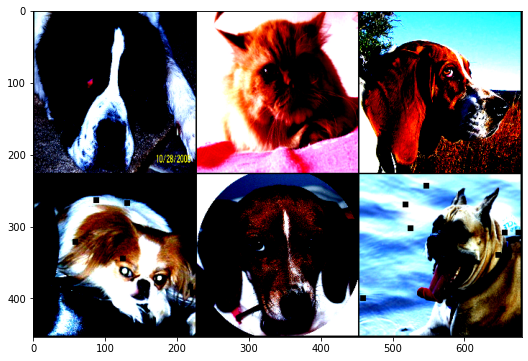

In [39]:
# displayig the data (looks this way because of normalization)
batch_tensor = next(iter(train_loader))[0][:6,...]
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=3)

# grid_img.shape
plt.figure(figsize=(16,6))
plt.imshow(grid_img.permute(1, 2, 0));

In [40]:
# setting up a model
model = config.model.to(device)
# loss
criterion = nn.MSELoss()
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)
# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, mode='min')

In [41]:
def train_model(n_epochs=1,
                model=model,
                train_loader=train_loader,
                valid_loader=valid_loader,
                criterion=criterion,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler):
    '''
    Main function for training.
    '''
    # start total time
    total_time = time.time()

    for epoch in range(n_epochs):
        # go to train mode
        model.train()
        # start epoch time
        t0 = time.time()
        # these will be used for metric calculations
        correct_on_epoch = 0
        total_num_images = 0
        epoch_loss = 0

        for batch, (images, labels) in enumerate(train_loader):

            # move images and labels to gpu, if available
            images = images.to(device, non_blocking=True).float()
            labels = labels.to(device, non_blocking=True).float()

            # keep track of total images in one epoch
            total_num_images += images.size(0)

            # clear grads before forward pass
            optimizer.zero_grad()

            # calculate outputs
            outputs = model(images)

            # we only need labels from (1,5) size tensor (both outputs and labels tensor), which is last digit
            preds = outputs[:, -1]
            preds = torch.clip(preds, 0, 1).round()
            true = labels[:, -1].round()

            # calculate the batch training loss
            loss = criterion(outputs, labels)

            # keep track of total epoch loss
            epoch_loss += loss

            # correct on bacth
            correct_on_batch = (preds == true).sum().item()

            # debugging
            # print(f'custom acc: {correct_on_batch/images.size(0)}')
            # print(f'preds: {preds[:10]}')
            # print(f'true: {true[:10]}')
            
            # correct on epoch
            correct_on_epoch += correct_on_batch
            # backward pass and step
            loss.backward()
            optimizer.step()

        # train acc/loss
        train_epoch_acc = round((correct_on_epoch/total_num_images), 4)
        train_avg_epoch_loss = round(float(epoch_loss/len(train_loader)), 4)
        # valid acc/loss
        valid_avg_epoch_loss, valid_epoch_accuracy, mean_iou = test_model(model, valid_loader)

        # epoch time
        epoch_time = round(time.time() - t0)
        # for reduce on plateau LR
        lr_scheduler.step(valid_avg_epoch_loss)

        print(f'epoch: [{epoch+1}/{n_epochs}] | train loss: {train_avg_epoch_loss} | train acc: {train_epoch_acc} | valid loss: {valid_avg_epoch_loss} | valid acc: {valid_epoch_accuracy} | iou: {mean_iou} | time: {epoch_time//60:.0f}m {epoch_time%60:.0f}s')

    return model

In [42]:
def test_model(model, test_loader):
    '''
    Main function for testing. Comments are almost identical to the train function.
    '''
    model.eval()

    correct_on_epoch = 0
    total_num_images = 0
    epoch_loss = 0
    epoch_iou = []

    all_batch_acc = []

    with torch.no_grad():

        for batch, (images, labels) in enumerate(test_loader):

            images = images.to(device, non_blocking=True).float()
            labels = labels.to(device, non_blocking=True).float()
            
            total_num_images += images.size(0)

            outputs = model(images)

            # preds and true are compared for valid accuracy
            preds = outputs[:, -1]
            preds = torch.clip(preds, 0, 1).round()
            true = labels[:, -1]

            true_bb = labels[:, :-1]
            pred_bb = outputs[:, :-1]

            loss = criterion(outputs, labels)
            epoch_loss += loss

            correct_on_epoch += (preds == true).sum().item()

            # batch iou
            batch_iou = iou(true_bb, pred_bb)
            epoch_iou.append(batch_iou)

    test_epoch_accuracy = round((correct_on_epoch/total_num_images), 4)
    test_avg_epoch_loss = round(float(epoch_loss/len(test_loader)), 4)
    mean_iou = np.round(np.mean(epoch_iou), 4)

    return test_avg_epoch_loss, test_epoch_accuracy, mean_iou

In [43]:
def iou(true_bb, pred_bb):
    '''
    Main function for calculating Intersection over Union
    '''
    batch_iou = []

    for idx, (true, pred) in enumerate(zip(true_bb, pred_bb)):

        pred = torch.clip(pred, min=0.0, max=1.0).detach().clone().to('cpu')
        true = torch.clip(true, min=0.0, max=1.0).detach().clone().to('cpu')

        xmin_t, ymin_t, xmax_t, ymax_t = true
        xmin_p, ymin_p, xmax_p, ymax_p = pred

        xmin_intersect = np.maximum(xmin_t, xmin_p)
        ymin_intersect = np.maximum(ymin_t, ymin_p)
        xmax_intersect = np.minimum(xmax_t, xmax_p)
        ymax_intersect = np.minimum(ymax_t, ymax_p)

        if xmin_intersect < xmax_intersect and ymin_intersect < ymax_intersect:

            intersection_area = (xmax_intersect - xmin_intersect) * (ymax_intersect - ymin_intersect)
            union_area = (xmax_t-xmin_t)*(ymax_t-ymin_t)+(xmax_p-xmin_p)*(ymax_p-ymin_p)-intersection_area + 1e-6

            assert intersection_area > 0, 'intersection area cant be < 0'
            assert union_area > 0, 'union area cant be < 0'

            iou = intersection_area / union_area
            batch_iou.append(iou)

        else:
            batch_iou.append(0.0)

    return np.round(np.mean(batch_iou), 4)

In [44]:
# unfreeze all the params for training
def unfreeze(model=model):
    '''
    This finction will unfreeze previously freezed params of our model so all the model's params will be available for training.
    '''
    for param in model.parameters():
        param.requires_grad = True
    return model

In [45]:
# %%time
train_model(config.frozen)
unfreeze()
train_model(15);

epoch: [1/3] | train loss: 0.0174 | train acc: 0.9793 | valid loss: 0.0133 | valid acc: 0.9941 | iou: 0.5809 | time: 0m 26s
epoch: [2/3] | train loss: 0.0173 | train acc: 0.9892 | valid loss: 0.0271 | valid acc: 0.9823 | iou: 0.5693 | time: 0m 26s
epoch: [3/3] | train loss: 0.0246 | train acc: 0.9557 | valid loss: 0.015 | valid acc: 0.9956 | iou: 0.6155 | time: 0m 26s
epoch: [1/15] | train loss: 0.026 | train acc: 0.9655 | valid loss: 0.0444 | valid acc: 0.9143 | iou: 0.6105 | time: 0m 26s
epoch: [2/15] | train loss: 0.0275 | train acc: 0.938 | valid loss: 0.0159 | valid acc: 0.9941 | iou: 0.6111 | time: 0m 26s
epoch: [3/15] | train loss: 0.0111 | train acc: 0.9956 | valid loss: 0.0084 | valid acc: 0.9985 | iou: 0.653 | time: 0m 26s
epoch: [4/15] | train loss: 0.0091 | train acc: 0.9941 | valid loss: 0.0083 | valid acc: 0.9985 | iou: 0.6392 | time: 0m 26s
epoch: [5/15] | train loss: 0.0087 | train acc: 0.998 | valid loss: 0.0083 | valid acc: 0.9985 | iou: 0.6452 | time: 0m 26s
epoch: [

In [46]:
# checkpoint = {'model': model,
#               'state_dict': model.state_dict()}

# torch.save(checkpoint, MODEL_OUTPUT)

In [47]:
%%time
# testing with train data
_, train_acc, train_iou = test_model(model, train_loader)
print(f'train acc: {train_acc} | train iou: {train_iou}')

train acc: 0.998 | train iou: 0.6884
CPU times: user 16.6 s, sys: 2.52 s, total: 19.1 s
Wall time: 20.6 s


In [48]:
%%time
# testing with test data
_, test_acc, test_iou = test_model(model, test_loader)
print(f'test acc: {test_acc} | test iou: {test_iou}')

test acc: 0.9956 | test iou: 0.6555
CPU times: user 4.79 s, sys: 831 ms, total: 5.62 s
Wall time: 6.13 s


In [49]:
%%time
# tta with test data
tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.five_crop_transform(config.tta_crop, config.tta_crop))

tta_dataset = dataset.localization_dataset(valid_df, transform=transforms.test_transform_loc)
tta_loader = DataLoader(tta_dataset, batch_size=1, shuffle=True)

_, tta_acc, tta_iou = test_model(tta_model, tta_loader)

print(f'TTA acc: {tta_acc} | tta iou: {tta_iou}')

TTA acc: 0.997 | tta iou: 0.5971
CPU times: user 12.3 s, sys: 608 ms, total: 12.9 s
Wall time: 13.4 s


In [50]:
total_time = time.time() - start
print(f'Total time: {total_time//60:.0f}m {total_time%60:.0f}s')

Total time: 8m 30s


# visualize predictions of the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


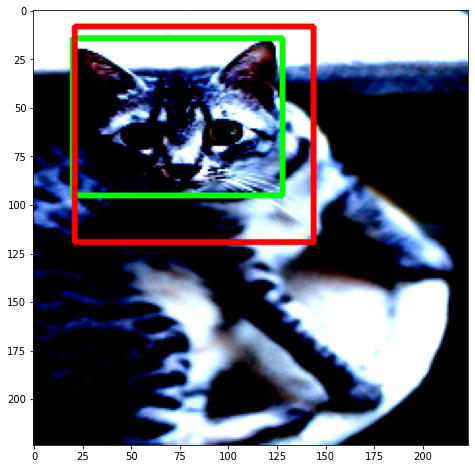

In [58]:
import cv2

with torch.no_grad():

    # build dataset
    temp_dataset = dataset.localization_dataset(df, transforms.test_transform_loc)
    # take a random picture from a dataset
    idx = np.random.randint(len(temp_dataset))

    image, label = temp_dataset[idx]
    # predict new bbox
    image = torch.unsqueeze(image, 0)
    model.to('cpu')
    outputs = model(image)
    outputs = outputs.flatten()
    pred_bb = np.round(outputs[:-1], 4).tolist() # <---- pred bb

    # convert ration bbox to pixels
    pred_start = (int(pred_bb[0]*config.crop), int(pred_bb[1]*config.crop))
    pred_end = (int(pred_bb[2]*config.crop), int(pred_bb[3]*config.crop))
    pred_id = outputs[-1].long().item()

    # need to permute tensor for visualization
    image = torch.squeeze(image, 0)
    image = np.array(image.permute(1, 2, 0))

    # bbox = first 4 digits
    bbox = np.round(label[:-1], 4).tolist() # <---- true bb

    # class = last digit
    class_id = label[-1].long().item()

    # define 2 points for rectangle
    start_point = (int(bbox[0]*config.crop), int(bbox[1]*config.crop))
    end_point = (int(bbox[2]*config.crop), int(bbox[3]*config.crop))

    # define a color and thickness
    color = (0, 255, 0)
    color2 = (255, 0, 0)

    thickness = 2

    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    image = cv2.rectangle(image, pred_start, pred_end, color2, thickness)

    # cv2.imshow('image', image)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.array(image));